In [103]:
from DipoleGroundState import MonoclinicLattice
import numpy as np
pi = np.pi
mB=9.274*10**(-24)
k=1.380*10**(-23)
NA=6.022*10**23
mu0=4*pi*10**(-7)
ErCl3 = MonoclinicLattice()
ErCl3.axes(9.57, 6.47, 7.84, 93.65*np.pi/180)
ErCl3.g_tensor(13.74, 0.75, 257*np.pi/180)
ErCl3.ion1_position(0.25, 0.1521, 0.25)
ErCl3.ion2_position(0.75, 0.8479, 0.75)

A_positions, A_labels = ErCl3.spherical_bravais_lattice(100,1,'A',1,'A')
B_positions, B_labels = ErCl3.spherical_bravais_lattice(100,1,'A',1,'B')
vertices = np.concatenate((A_positions,B_positions),axis=0)
ion_vector = ErCl3.position['1A']

factor = (mu0)/(4*pi)/((10**(-10))**3)
rx = vertices[:,0] - ion_vector[0]
ry = vertices[:,1] - ion_vector[1]
rz = vertices[:,2] - ion_vector[2]
rtot = np.sqrt(np.sum(np.power(vertices - ion_vector,2),axis=1))
mux = 0
muy = 0
muz = 0.5*mB*ErCl3.gz

Bx_each_ion = (3*(muz*rz)*rx)/(rtot**5)
By_each_ion = (3*(muz*rz)*ry)/(rtot**5)
Bz_each_ion = -(muz/rtot**3) + (3*(muz*rz)*rz)/(rtot**5)

def field(Bxs,Bys,Bzs,vertices):    
    randoms_orientations = np.sign(np.random.rand(len(vertices))-0.5)
    Bx = factor*np.sum(Bxs*randoms_orientations)
    By = factor*np.sum(Bys*randoms_orientations)
    Bz = factor*np.sum(Bzs*randoms_orientations)
    
    return (Bx, By, Bz)

sample = np.empty((100000,3))
for i in range(100000):
    sample[i] = field(Bx_each_ion,By_each_ion,Bz_each_ion,vertices)

(array([1.000e+01, 2.500e+01, 8.400e+01, 2.290e+02, 4.500e+02, 8.520e+02,
        1.476e+03, 2.365e+03, 3.345e+03, 4.783e+03, 6.073e+03, 7.400e+03,
        8.622e+03, 9.341e+03, 9.559e+03, 9.156e+03, 8.709e+03, 7.473e+03,
        6.179e+03, 4.853e+03, 3.508e+03, 2.318e+03, 1.514e+03, 8.300e+02,
        4.680e+02, 2.550e+02, 7.900e+01, 3.300e+01, 7.000e+00, 4.000e+00]),
 array([-0.22680643, -0.21118938, -0.19557234, -0.1799553 , -0.16433825,
        -0.14872121, -0.13310416, -0.11748712, -0.10187007, -0.08625303,
        -0.07063599, -0.05501894, -0.0394019 , -0.02378485, -0.00816781,
         0.00744924,  0.02306628,  0.03868333,  0.05430037,  0.06991741,
         0.08553446,  0.1011515 ,  0.11676855,  0.13238559,  0.14800264,
         0.16361968,  0.17923672,  0.19485377,  0.21047081,  0.22608786,
         0.2417049 ]),
 <a list of 30 Patch objects>)

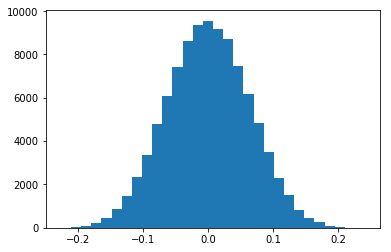

In [104]:
import matplotlib.pyplot as plt
plt.hist(sample[:,2]*1,30)